Author: Radhimas Januar Rachman (radhimasjanuar@gmail.com) - March, 2024.

## HOME CREDIT SCORE MODEL PREDICTION

**Background:**

Numerous individuals encounter difficulties in securing loans because of limited or absent credit records. Home Credit aims to expand financial access for those without banking services by offering a secure and favorable borrowing environment. To ensure a positive loan journey for this underserved demographic, Home Credit utilizes diverse alternative data sources to assess their clients' repayment capacities. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

**Objective:**

1. Identify characteristics of potential clients who will have difficulty repaying loans.
2. Predict client’s repayment abilities.

**Actions:**

1. Conduct data cleansing and visualization to get business insights.
2. Construct models using machine learning algorithms and determine the most optimal model.
3. Provide recommendations for the company to enhancing the success rate of clients' loan applications.

## Load Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('application_train.csv')

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

* The data consists of **307511 rows** and **122 features**.
* The `TARGET` feature has a definition if the customer has a payment problem such as late installment payments. These customers are labeled with a value of 1 while those without payment problems are labeled with a value of 0.

## Exploratory Data Analysis (EDA)

In [5]:
df_train = df.copy()

### Univariate Analysis

In [6]:
label_map = {0: 'Kredit Lancar', 1: 'Kredit Bermasalah'}

# Apply the mapping to the 'TARGET' column
df_train['TARGET_label'] = df_train['TARGET'].map(label_map)

In [7]:
target_group = df_train.groupby('TARGET_label').agg({'SK_ID_CURR':'count'}).reset_index()
target_group.columns = ['TARGET_label', 'total']
target_group['%'] = round(target_group['total'] * 100 / sum(target_group['total']), 3)
print(target_group)

        TARGET_label   total       %
0  Kredit Bermasalah   24825   8.073
1      Kredit Lancar  282686  91.927


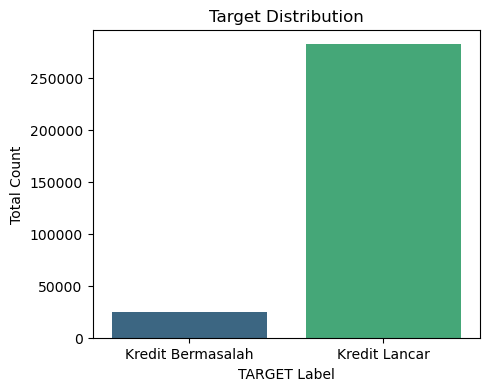

In [8]:
plt.figure(figsize=(5, 4))
sns.barplot(x='TARGET_label', y='total', data=target_group, palette='viridis')
plt.title('Target Distribution')
plt.ylabel('Total Count')
plt.xlabel('TARGET Label')
plt.show()

* Of the total observed loans, only about 8.073% are classified as "Kredit Bermasalah"(Have payment difficulties). This indicates that the majority of loans (91.927%) in the dataset are considered current/ "Kredit Lancar".
* This target feature is imbalanced. It is necessary to use resampling method to overcome the problem in the data preprocessing stage.

### Bivariate Analysis(Categorical)

#### Contract Type vs Target Label

In [9]:
ct_group = df_train.groupby(['NAME_CONTRACT_TYPE', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
ct_group.columns = ['NAME_CONTRACT_TYPE', 'TARGET_label', 'total']
ct_group = ct_group.sort_values(by='total', ascending=False)
ct_group

,NAME_CONTRACT_TYPE,TARGET_label,total
1,Cash loans,Kredit Lancar,255011
3,Revolving loans,Kredit Lancar,27675
0,Cash loans,Kredit Bermasalah,23221
2,Revolving loans,Kredit Bermasalah,1604


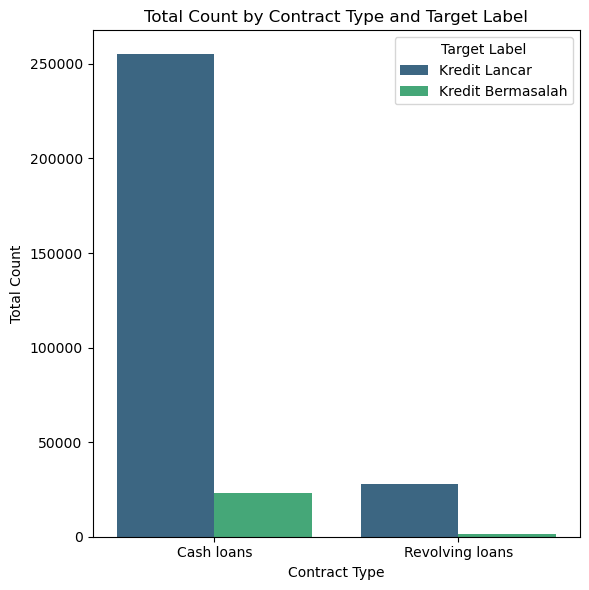

In [10]:
plt.figure(figsize=(6, 6))
sns.barplot(x='NAME_CONTRACT_TYPE', y='total', hue='TARGET_label', data=ct_group, palette='viridis')
plt.xlabel('Contract Type')
plt.ylabel('Total Count')
plt.title('Total Count by Contract Type and Target Label')
plt.legend(title='Target Label')
plt.tight_layout()
plt.show()

* The proportion of "kredit bermasalah" is relatively lower for Cash loans (23.2K) compared to Revolving loans (1.6K). This suggests that clients using Revolving loans tend to have a slightly higher level of non-performing loan risk compared to Cash loans.

#### Gender Type vs Target Label

In [11]:
gnr_group = df_train.groupby(['CODE_GENDER', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
gnr_group.columns = ['CODE_GENDER', 'TARGET_label', 'total']
gnr_group = gnr_group.sort_values(by='total', ascending=False)
gnr_group

,CODE_GENDER,TARGET_label,total
1,F,Kredit Lancar,188278
3,M,Kredit Lancar,94404
0,F,Kredit Bermasalah,14170
2,M,Kredit Bermasalah,10655
4,XNA,Kredit Lancar,4


* The majority of loans for both female and male genders are classified as "Kredit Lancar"(current).
* The number of "kredit bermasalah" (non-performing loans) is also significant, especially for individuals of female gender, as more loans were made to individuals of female (F) gender compared to male (M).

#### Car Ownership vs Target Label

In [12]:
car_group = df_train.groupby(['FLAG_OWN_CAR', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
car_group.columns = ['FLAG_OWN_CAR', 'TARGET_label', 'total']
car_group = car_group.sort_values(by='total', ascending=False)
car_group

,FLAG_OWN_CAR,TARGET_label,total
1,N,Kredit Lancar,185675
3,Y,Kredit Lancar,97011
0,N,Kredit Bermasalah,17249
2,Y,Kredit Bermasalah,7576


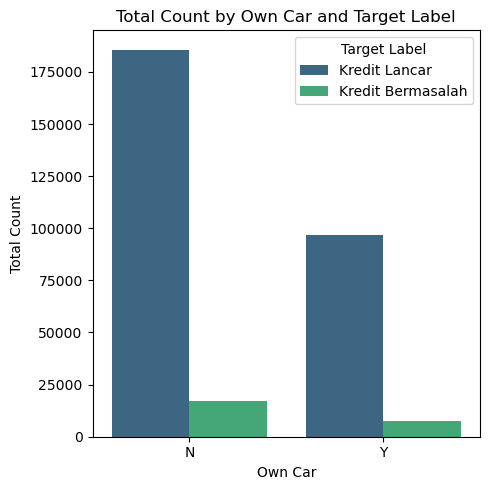

In [13]:
plt.figure(figsize=(5, 5))
sns.barplot(x='FLAG_OWN_CAR', y='total', hue='TARGET_label', data=car_group, palette='viridis')
plt.xlabel('Own Car')
plt.ylabel('Total Count')
plt.title('Total Count by Own Car and Target Label')
plt.legend(title='Target Label')
plt.tight_layout()
plt.show()

* The majority of clients (185K) who do not own a car have current credit. This shows that not owning a car does not hinder one's ability to pay their credit smoothly.

#### Realty Ownership Status vs Target Label

In [14]:
rlt_group = df_train.groupby(['FLAG_OWN_REALTY', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
rlt_group.columns = ['FLAG_OWN_REALTY', 'TARGET_label', 'total']
rlt_group = rlt_group.sort_values(by='total', ascending=False)
rlt_group

,FLAG_OWN_REALTY,TARGET_label,total
3,Y,Kredit Lancar,196329
1,N,Kredit Lancar,86357
2,Y,Kredit Bermasalah,16983
0,N,Kredit Bermasalah,7842


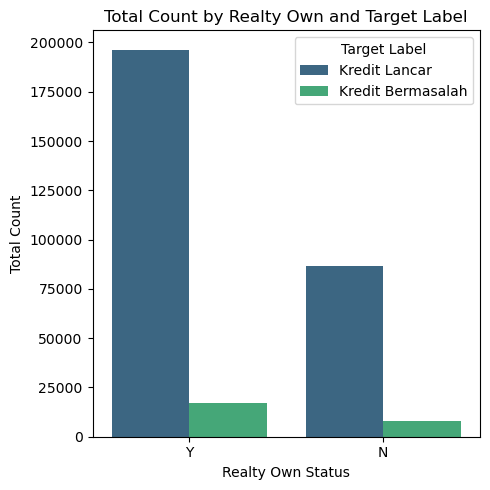

In [15]:
plt.figure(figsize=(5, 5))
sns.barplot(x='FLAG_OWN_REALTY', y='total', hue='TARGET_label', data=rlt_group, palette='viridis')
plt.xlabel('Realty Own Status')
plt.ylabel('Total Count')
plt.title('Total Count by Realty Own and Target Label')
plt.legend(title='Target Label')
plt.tight_layout()
plt.show()

* The number of clients who own property ('Y') but have payment difficulties (16K) is higher than clients who do not own property ('N') but have payment difficulties (7K).
* There are more clients who own property than clients who do not own property.

#### Income Type vs Target Label

In [16]:
income_group = df_train.groupby(['NAME_INCOME_TYPE', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
income_group.columns = ['NAME_INCOME_TYPE', 'TARGET_label', 'total']
income_group = income_group.sort_values(by='total', ascending=False)
income_group

,NAME_INCOME_TYPE,TARGET_label,total
13,Working,Kredit Lancar,143550
2,Commercial associate,Kredit Lancar,66257
6,Pensioner,Kredit Lancar,52380
8,State servant,Kredit Lancar,20454
12,Working,Kredit Bermasalah,15224
1,Commercial associate,Kredit Bermasalah,5360
5,Pensioner,Kredit Bermasalah,2982
7,State servant,Kredit Bermasalah,1249
9,Student,Kredit Lancar,18
11,Unemployed,Kredit Lancar,14


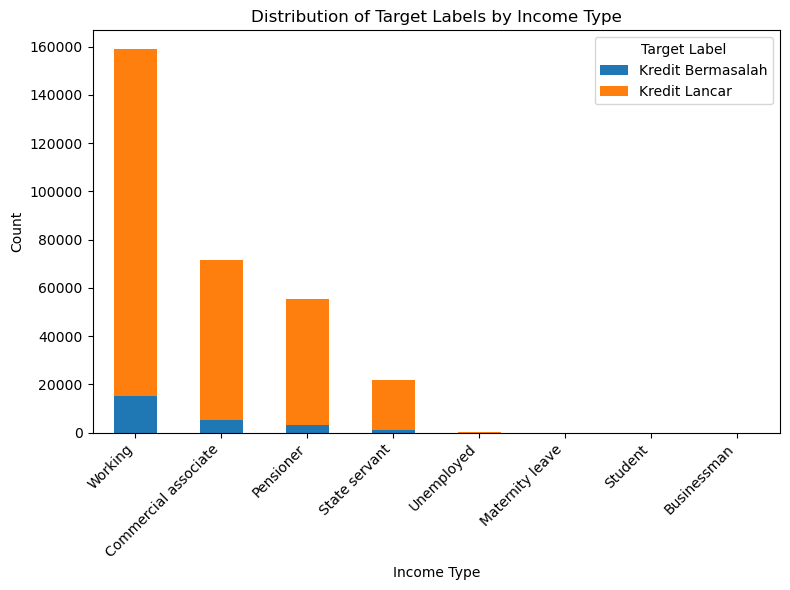

In [17]:
pivot_income_group = income_group.pivot(index='NAME_INCOME_TYPE', columns='TARGET_label', values='total')
pivot_income_group = pivot_income_group.sort_values(by='Kredit Lancar', ascending=False)
pivot_income_group = pivot_income_group.sort_values(by='Kredit Bermasalah', ascending=False)


pivot_income_group.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribution of Target Labels by Income Type')
plt.xlabel('Income Type')
plt.ylabel('Count')
plt.legend(title='Target Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


* The majority of 'Working', 'Commercial associate', 'Pensioner' and 'State servant' clients have a "Kredit lancar"(current) credit status. While the number of clients with "Kredit bermasalah"(non-performing credit status) is relatively less compared to the total number of clients in these categories

#### Education Type Vs Target Label

In [18]:
edu_group = df_train.groupby(['NAME_EDUCATION_TYPE', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
edu_group.columns = ['NAME_EDUCATION_TYPE', 'TARGET_label', 'total']
edu_group = edu_group.sort_values(by='total', ascending=False)
edu_group

,NAME_EDUCATION_TYPE,TARGET_label,total
9,Secondary / secondary special,Kredit Lancar,198867
3,Higher education,Kredit Lancar,70854
8,Secondary / secondary special,Kredit Bermasalah,19524
5,Incomplete higher,Kredit Lancar,9405
2,Higher education,Kredit Bermasalah,4009
7,Lower secondary,Kredit Lancar,3399
4,Incomplete higher,Kredit Bermasalah,872
6,Lower secondary,Kredit Bermasalah,417
1,Academic degree,Kredit Lancar,161
0,Academic degree,Kredit Bermasalah,3


* The majority of clients have Secondary / secondary special and Higher education, and clients with higher education, tend to have a higher number of "kredit Lancar"(current) loans than those with lower education.
* "Kredit Bermasalah"(Non-performing loans) are generally lower than current loans in each education category.

#### Occupation Type vs Target Label

In [19]:
job_group = df_train.groupby(['OCCUPATION_TYPE', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
job_group.columns = ['OCCUPATION_TYPE', 'TARGET_label', 'total']
job_group = job_group.sort_values(by='total', ascending=False)
job_group

,OCCUPATION_TYPE,TARGET_label,total
17,Laborers,Kredit Lancar,49348
29,Sales staff,Kredit Lancar,29010
7,Core staff,Kredit Lancar,25832
21,Managers,Kredit Lancar,20043
9,Drivers,Kredit Lancar,16496
13,High skill tech staff,Kredit Lancar,10679
1,Accountants,Kredit Lancar,9339
23,Medicine staff,Kredit Lancar,7965
33,Security staff,Kredit Lancar,5999
16,Laborers,Kredit Bermasalah,5838


* "Laborers" is the most common occupation in the data, and also tends to have a higher number of "kredit Lancar"(current) loans than "Kredit Bermasalah"(non-performing loans).
* "Laborers" is also the occupation with the highest number of "Kredit Bermasalah"(non-performing loans), indicating a potential risk in this category.

### Bivariate Analysis(Numerical)

In [20]:
amnt_group = df_train.groupby(['AMT_CREDIT', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
amnt_group.columns = ['AMT_CREDIT', 'TARGET_label', 'total']
amnt_group = amnt_group.sort_values(by='total', ascending=False)

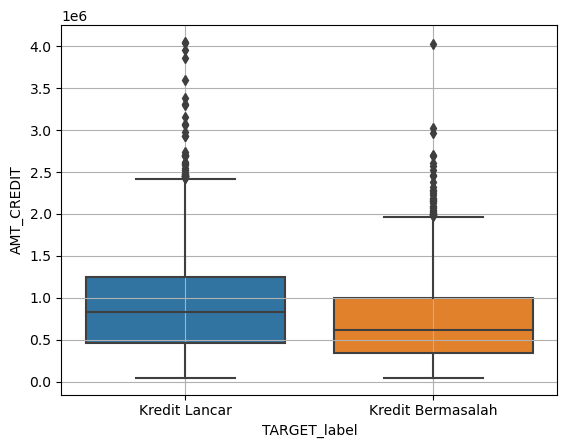

In [21]:
sns.boxplot(x='TARGET_label', y='AMT_CREDIT', data=amnt_group)
plt.grid()
plt.show()

It can be seen that the median amount of credit for clients who are current in their payments ("Kredit Lancar") is slightly higher than the median amount of credit for clients who have payment problems ("Kredit Bermasalah"). This means that clients with higher credit loans ("Amount Credit") are slightly more likely to be able to repay their loans than clients with lower credit amounts.

#### Age vs Target Label

In [22]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 123 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [23]:
df_train.sample()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET_label
278657,422835,0,Cash loans,F,N,Y,0,247500.0,545040.0,26640.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,Kredit Lancar


In [24]:
df_train['AGE'] = (-df_train['DAYS_BIRTH'] / 365.25).astype(int)

# Display the first few rows to verify
print(df_train[['DAYS_BIRTH', 'AGE']].head(10))

   DAYS_BIRTH  AGE
0       -9461   25
1      -16765   45
2      -19046   52
3      -19005   52
4      -19932   54
5      -16941   46
6      -13778   37
7      -18850   51
8      -20099   55
9      -14469   39


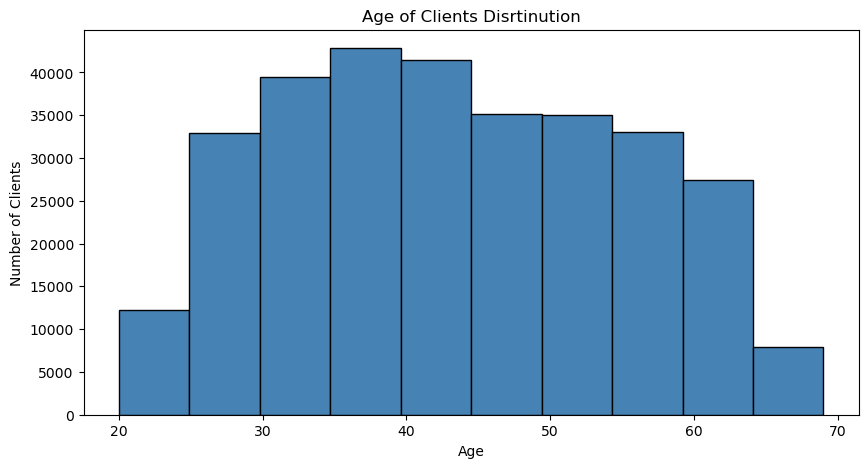

In [25]:
plt.figure(figsize=(10,5))
plt.hist(df_train['AGE'], bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Clients Disrtinution')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

* Clients are generally around 30-40 years old.

In [26]:
age_group = df_train.groupby(['AGE', 'TARGET_label']).agg({'SK_ID_CURR':'count'}).reset_index()
age_group.columns = ['AGE', 'TARGET_label', 'total']
age_group = age_group.sort_values(by='total', ascending=False)

In [27]:
age_group_lancar = age_group[age_group['TARGET_label'] == 'Kredit Lancar']
age_group_bermasalah = age_group[age_group['TARGET_label'] == 'Kredit Bermasalah']

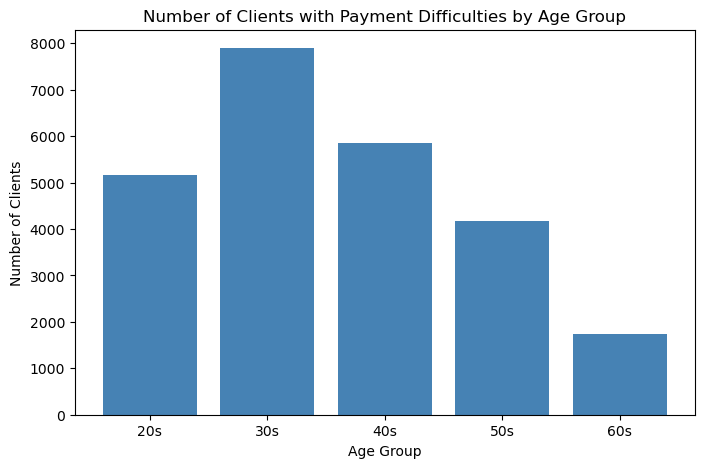

In [28]:
age_ranges = ['20s', '30s', '40s', '50s', '60s']

# Group ages into ranges
age_counts = {
    '20s': age_group_bermasalah[(age_group_bermasalah['AGE'] >= 20) & (age_group_bermasalah['AGE'] < 30)]['total'].sum(),
    '30s': age_group_bermasalah[(age_group_bermasalah['AGE'] >= 30) & (age_group_bermasalah['AGE'] < 40)]['total'].sum(),
    '40s': age_group_bermasalah[(age_group_bermasalah['AGE'] >= 40) & (age_group_bermasalah['AGE'] < 50)]['total'].sum(),
    '50s': age_group_bermasalah[(age_group_bermasalah['AGE'] >= 50) & (age_group_bermasalah['AGE'] < 60)]['total'].sum(),
    '60s': age_group_bermasalah[(age_group_bermasalah['AGE'] >= 60)]['total'].sum()
}

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(age_counts.keys(), age_counts.values(), color='steelblue')
plt.title('Number of Clients with Payment Difficulties by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Clients')
plt.show()

* Clients with credit repayment problems were most likely to be in their 30s, while the least likely to have credit repayment problems were around their 60s.

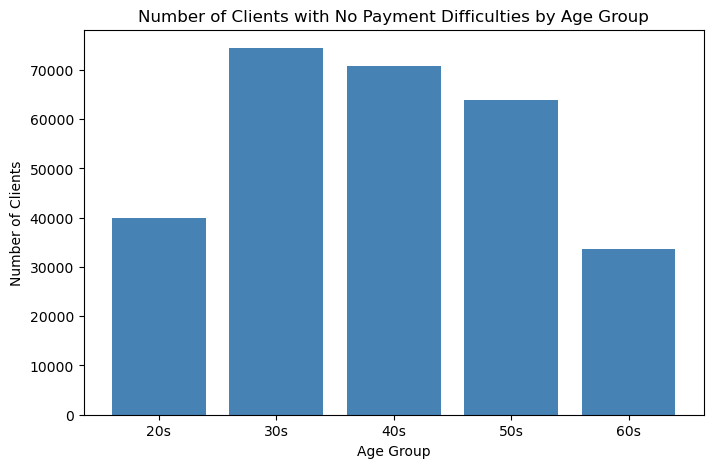

In [29]:
age_ranges = ['20s', '30s', '40s', '50s', '60s']

# Group ages into ranges
age_counts = {
    '20s': age_group_lancar[(age_group_lancar['AGE'] >= 20) & (age_group_lancar['AGE'] < 30)]['total'].sum(),
    '30s': age_group_lancar[(age_group_lancar['AGE'] >= 30) & (age_group_lancar['AGE'] < 40)]['total'].sum(),
    '40s': age_group_lancar[(age_group_lancar['AGE'] >= 40) & (age_group_lancar['AGE'] < 50)]['total'].sum(),
    '50s': age_group_lancar[(age_group_lancar['AGE'] >= 50) & (age_group_lancar['AGE'] < 60)]['total'].sum(),
    '60s': age_group_lancar[(age_group_lancar['AGE'] >= 60)]['total'].sum()
}

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(age_counts.keys(), age_counts.values(), color='steelblue')
plt.title('Number of Clients with No Payment Difficulties by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Clients')
plt.show()

* Clients with no credit repayment problems are generally to be in their 30s to 40s.

## Data Cleaning

### Check Missing Value

In [30]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Auto-adjust width

In [31]:
# Hitung jumlah nilai null dalam setiap kolom
jumlah_null = df_train.isnull().sum()

# Hitung rasio nilai null terhadap total jumlah baris dalam dataset
rasio_null = (jumlah_null / len(df_train)) * 100

# Buat DataFrame baru untuk menampilkan kolom-kolom yang memiliki nilai null dan rasio nullnya
df_train_info = pd.DataFrame({
    'Jumlah Null': jumlah_null,
    'Rasio Null (%)': rasio_null
})
print(df_train_info.sort_values(by='Jumlah Null', ascending=False))

                              Jumlah Null  Rasio Null (%)
COMMONAREA_MODE                    214865       69.872297
COMMONAREA_AVG                     214865       69.872297
COMMONAREA_MEDI                    214865       69.872297
NONLIVINGAPARTMENTS_MEDI           213514       69.432963
NONLIVINGAPARTMENTS_AVG            213514       69.432963
NONLIVINGAPARTMENTS_MODE           213514       69.432963
FONDKAPREMONT_MODE                 210295       68.386172
LIVINGAPARTMENTS_MEDI              210199       68.354953
LIVINGAPARTMENTS_AVG               210199       68.354953
LIVINGAPARTMENTS_MODE              210199       68.354953
FLOORSMIN_MEDI                     208642       67.848630
FLOORSMIN_AVG                      208642       67.848630
FLOORSMIN_MODE                     208642       67.848630
YEARS_BUILD_AVG                    204488       66.497784
YEARS_BUILD_MODE                   204488       66.497784
YEARS_BUILD_MEDI                   204488       66.497784
OWN_CAR_AGE   

In [32]:
# drop fitur yang memiliki missing value diatas 40%
threshold = 40.0
null_threshold = df_train_info[df_train_info['Rasio Null (%)'] > threshold]
columns_to_drop = null_threshold.index
df_train_cleaned = df_train.drop(columns=columns_to_drop)

In [33]:
df_train_cleaned.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

### Distribution Plot Numerical Features

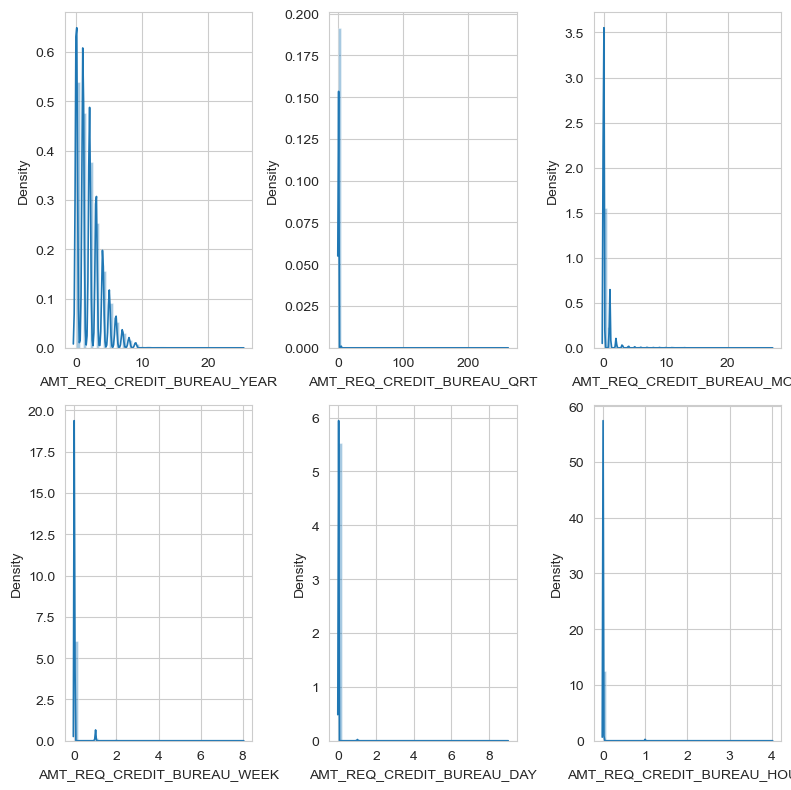

In [34]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
fig, ax = plt.subplots(2, 3, figsize=(8, 8))  
sns.set_context('paper', font_scale=1)

sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])
sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])
sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][2])  
sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])
sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])
sns.distplot(df_train_cleaned['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[1][2])

plt.tight_layout()
plt.show()

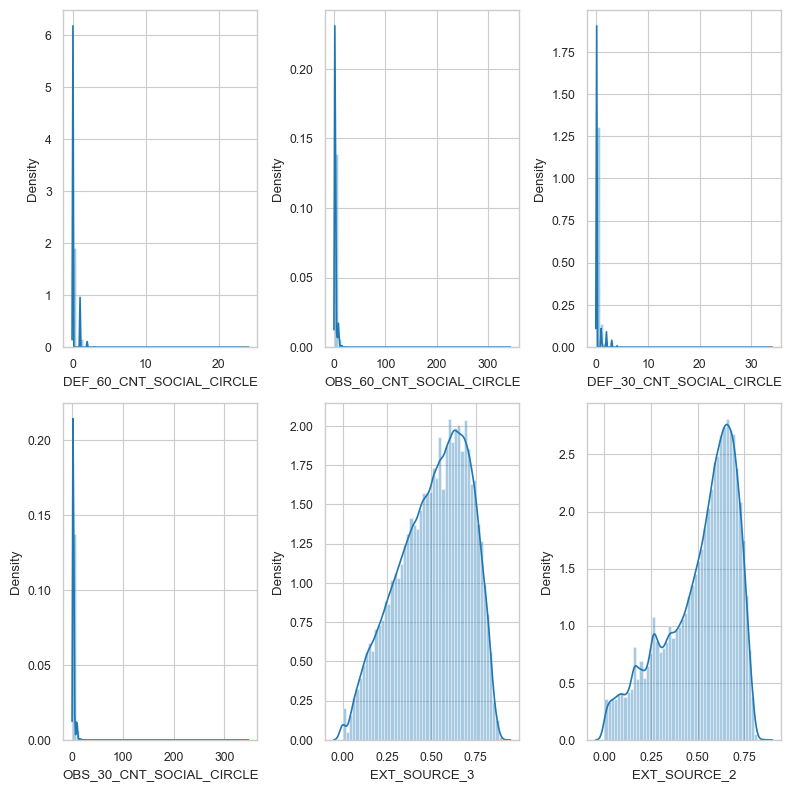

In [35]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, 3, figsize=(8, 8))  
sns.set_context('paper', font_scale=1)

sns.distplot(df_train_cleaned['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])
sns.distplot(df_train_cleaned['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])
sns.distplot(df_train_cleaned['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[0][2])  
sns.distplot(df_train_cleaned['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])
sns.distplot(df_train_cleaned['EXT_SOURCE_3'], ax=ax[1][1])
sns.distplot(df_train_cleaned['EXT_SOURCE_2'], ax=ax[1][2])

plt.tight_layout()
plt.show()

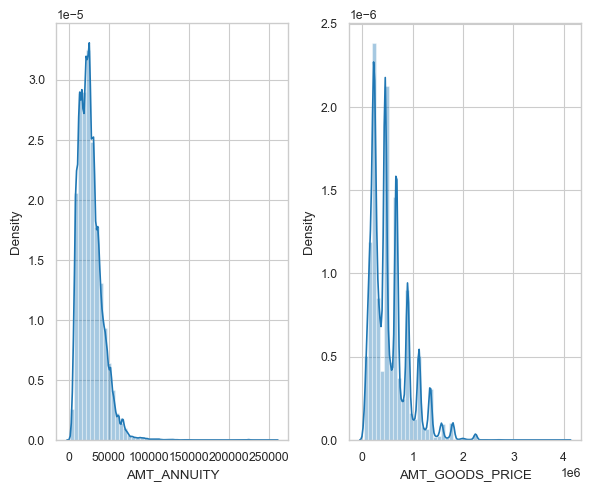

In [36]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(6, 5))  
sns.set_context('paper', font_scale=1)

sns.distplot(df_train_cleaned['AMT_ANNUITY'], ax=ax[0])
sns.distplot(df_train_cleaned['AMT_GOODS_PRICE'], ax=ax[1])

plt.tight_layout()
plt.show()

* Based on the results of the distribution plot of numerical features showing a right-skewed distribution, imputation using the median will be performed.

In [37]:
# imputasi untuk numerical dengan median dan modus untuk categorical
catg_column = df_train_cleaned.select_dtypes(include=['object']).columns.tolist()
nums_column = df_train_cleaned.select_dtypes(include=['int64','float64']).columns.tolist()

for x in df_train_cleaned:
    if df_train_cleaned[x].isnull().any():
        if(x in catg_column):
            df_train_cleaned[x]=df_train_cleaned[x].fillna(df_train_cleaned[x].mode()[0])
        else:
            df_train_cleaned[x]=df_train_cleaned[x].fillna(df_train_cleaned[x].median())

In [38]:
df_train_cleaned.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RAT

### Check Duplicate Value

In [39]:
df_train_cleaned.duplicated().sum()

0

### Hanlde Outliers

In [40]:
nums = []
catg = []
for i in df_train_cleaned.columns:
    if df_train_cleaned[i].dtype == 'object':
        catg.append(i)
    else:
        nums.append(i)
print('total = ',len(nums))
print('nums = ',nums)
print('total = ',len(catg))
print('catg = ',catg)

total =  62
nums =  ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13'

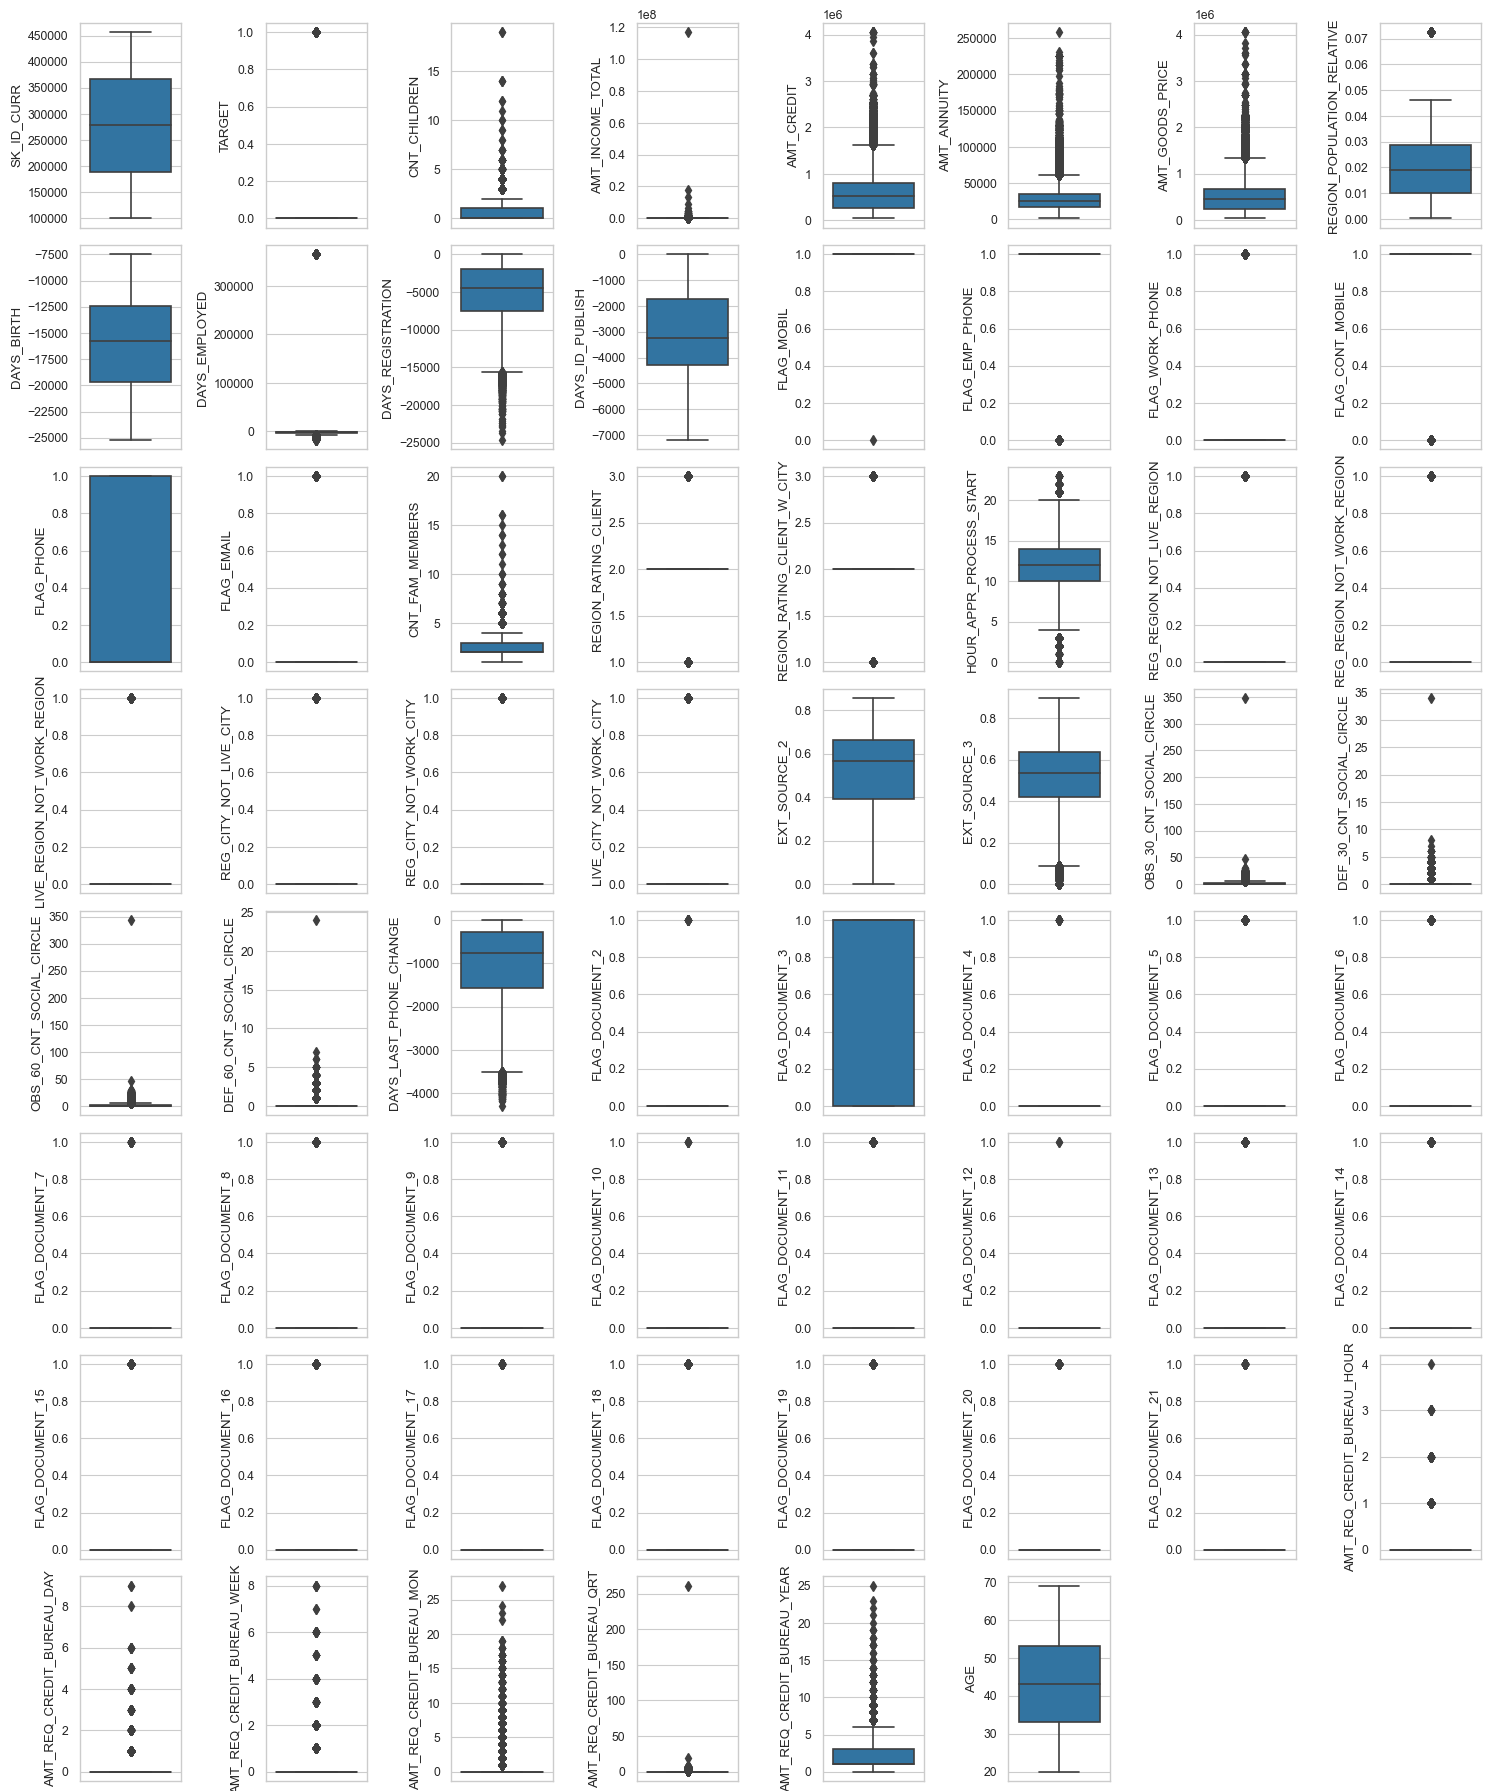

In [41]:
# detect outliers
plt.figure(figsize=(15,18))
for i in range(0,len(nums)):
    plt.subplot(8, 8, i+1)
    sns.boxplot(y = df_train_cleaned[nums[i]])
    plt.tight_layout()

In [42]:
def handle_outliers_iqr(df, column):
    # Calculate the first quartile (Q1)
    Q1 = df[column].quantile(0.25)
    # Calculate the third quartile (Q3)
    Q3 = df[column].quantile(0.75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Replace the outliers with the appropriate threshold values
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Apply the handle_outliers_iqr function to all numerical columns except "TARGET"
for col in nums:
    if col != 'TARGET':
        df_train_cleaned = handle_outliers_iqr(df_train_cleaned, col)

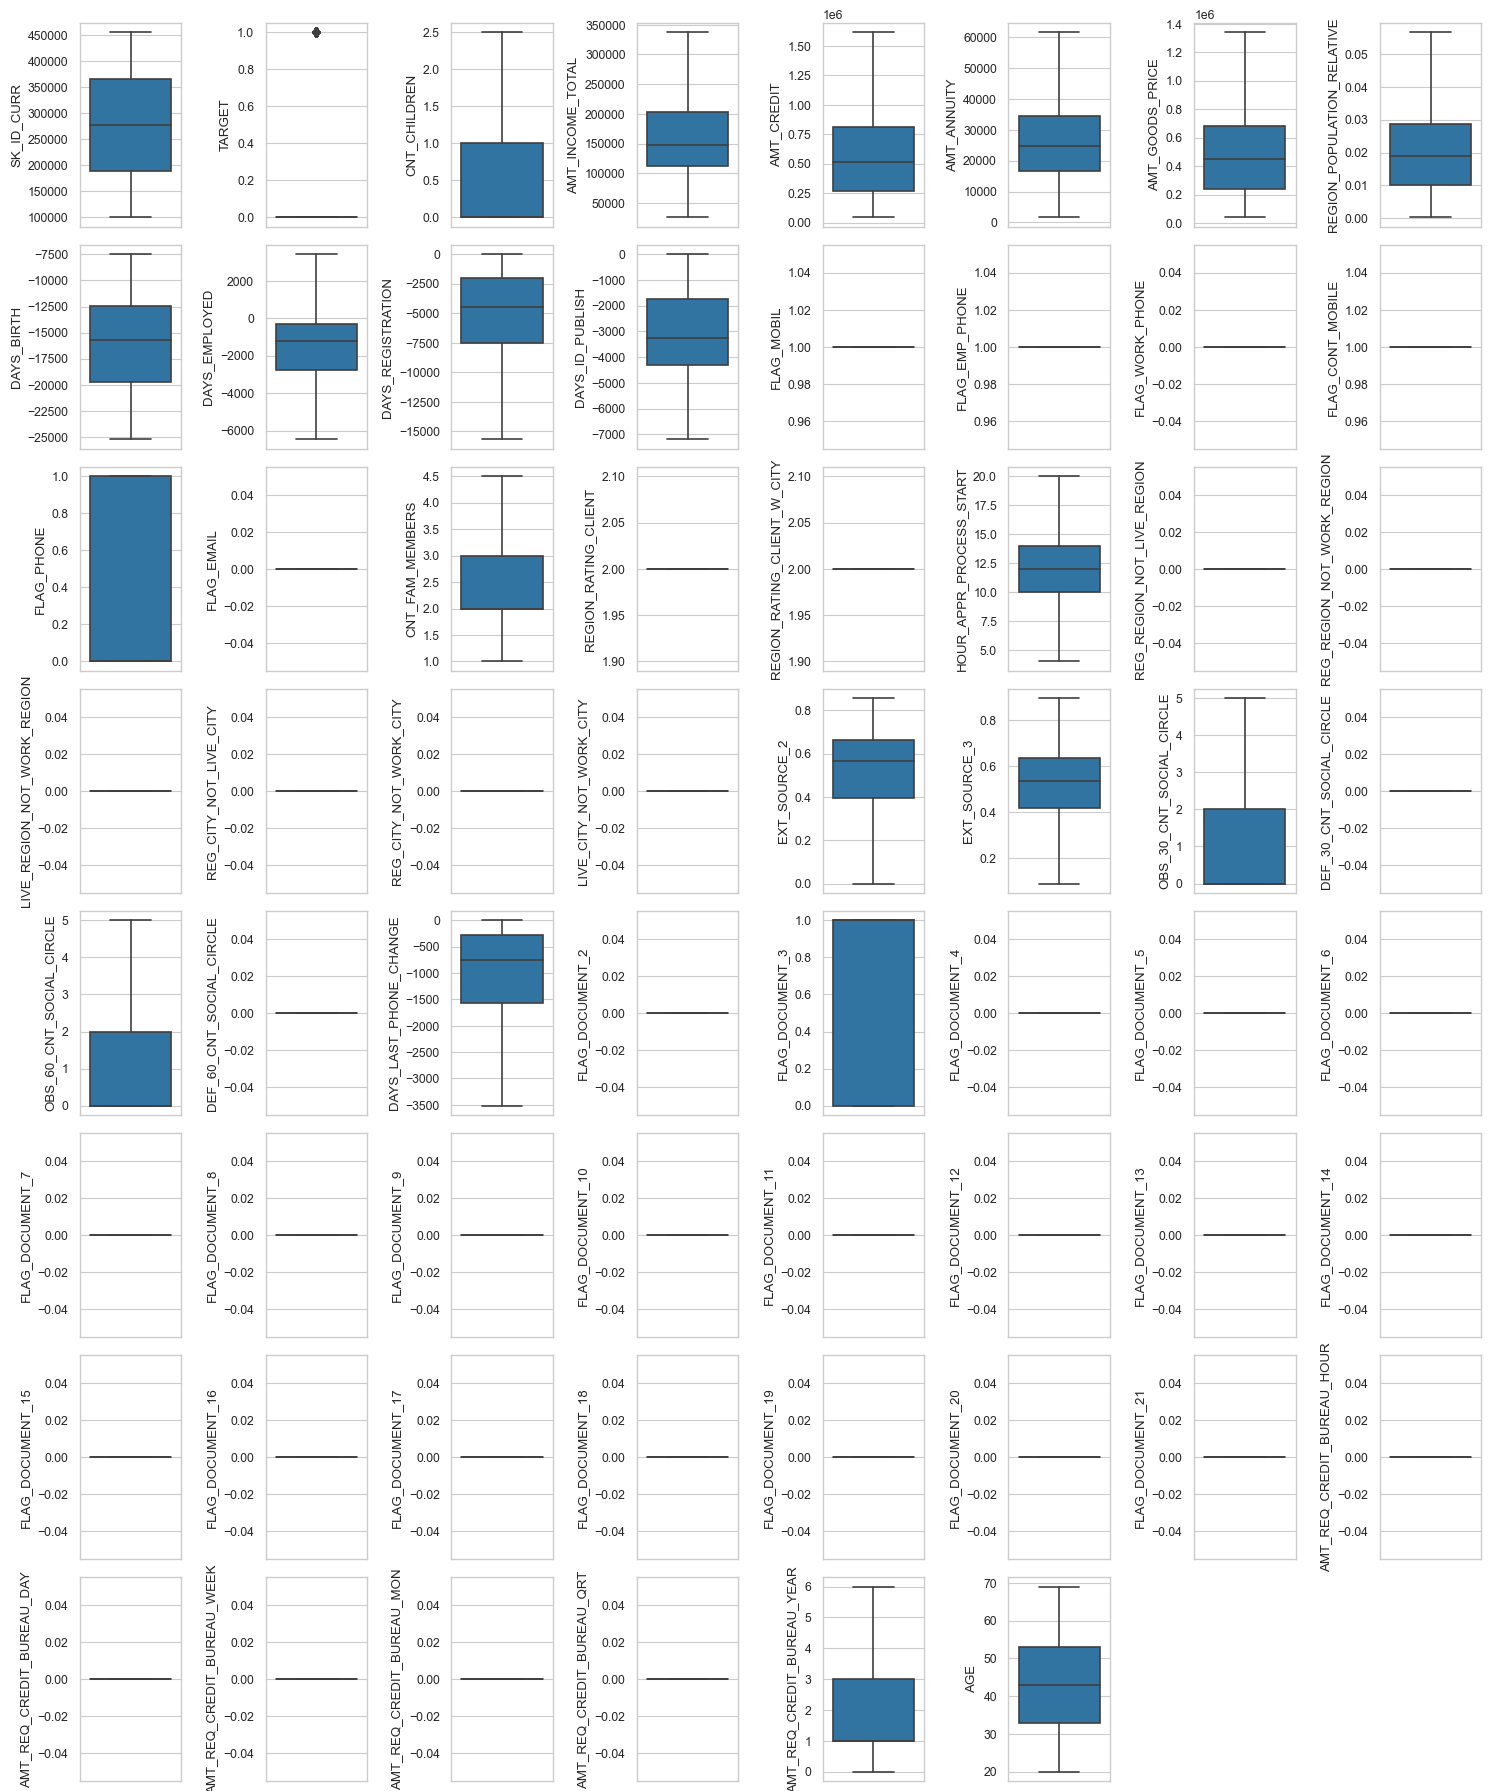

In [43]:
# Setelah hanlde outliers
plt.figure(figsize=(15,18))
for i in range(0,len(nums)):
    plt.subplot(8, 8, i+1)
    sns.boxplot(y = df_train_cleaned[nums[i]])
    plt.tight_layout()

### Feature Encoding

In [44]:
df_train_cleaned.select_dtypes(include='object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
TARGET_label                   2
dtype: int64

* `ORGANIZATION_TYPE` has too many unique values so it will be dropped.
* `TARGET_label` is no longer needed so it will be dropped.

In [45]:
df_train_cleaned.drop('ORGANIZATION_TYPE', axis = 1, inplace= True)
df_train_cleaned.drop('TARGET_label', axis = 1, inplace= True)

In [46]:
categorical_cols = [col for col in df_train_cleaned.select_dtypes(include='object').columns.tolist()]

In [47]:
onehot = pd.get_dummies(df_train_cleaned[categorical_cols], drop_first=True)

In [48]:
onehot.head()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,True,True,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [49]:
# concat onehot ke dataframe
df_train_cleaned = pd.concat([df_train_cleaned, onehot], axis=1)

In [50]:
# Drop fitur kategorikal yang sudah dilakukan one-hot endocing
df_train_cleaned.drop(categorical_cols, axis=1, inplace=True)

In [51]:
df_train_cleaned.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 117 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    SK_ID_CURR                                         float64
 1    TARGET                                             int64  
 2    CNT_CHILDREN                                       float64
 3    AMT_INCOME_TOTAL                                   float64
 4    AMT_CREDIT                                         float64
 5    AMT_ANNUITY                                        float64
 6    AMT_GOODS_PRICE                                    float64
 7    REGION_POPULATION_RELATIVE                         float64
 8    DAYS_BIRTH                                         float64
 9    DAYS_EMPLOYED                                      float64
 10   DAYS_REGISTRATION                                  float64
 11   DAYS_ID_PUBLISH                      

* `SK_ID_CURR` is not required and will be dropped.

In [52]:
df_train_cleaned.drop('SK_ID_CURR', axis = 1, inplace= True)

### Change negative values to positive

In [53]:
df_train_cleaned.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262949,0.139376,2.0,0.0,2.0,0.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fals

* Features that have negative values are `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, and
`DAYS_LAST_PHONE_CHANGE`.

In [54]:
features_with_negative_values = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
                                 'DAYS_LAST_PHONE_CHANGE']

for feature in features_with_negative_values:
    df_train_cleaned[feature] = df_train_cleaned[feature].abs()

In [55]:
df_train_cleaned.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,637.0,3648.0,2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262949,0.139376,2.0,0.0,2.0,0.0,1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,1188.0,1186.0,291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622246,0.535276,1.0,0.0,1.0,0.0,828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

### Feature Selection

In [56]:
x = df_train_cleaned.drop(['TARGET'], axis=1)
y = df_train_cleaned['TARGET']

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
featureScores.sort_values(by=['Score'], ascending=False)

,Features,Score
4,AMT_GOODS_PRICE,9.855969e+07
2,AMT_CREDIT,6.520411e+07
1,AMT_INCOME_TOTAL,5.127019e+06
7,DAYS_EMPLOYED,2.667535e+06
6,DAYS_BIRTH,2.235391e+06
8,DAYS_REGISTRATION,1.342797e+06
32,DAYS_LAST_PHONE_CHANGE,6.649623e+05
9,DAYS_ID_PUBLISH,6.195946e+05
3,AMT_ANNUITY,1.863401e+05
59,AGE,6.182067e+03


* There are features that have a low correlation score compared to other features including:
`FLAG_EMP_PHONE`, `REGION_RATING_CLIENT`, `FLAG_MOBILE`, `FLAG_CONT_MOBILE`, and `REGION_RATING_CLIENT_W_CITY`.
* Based on the correlation score results, the modeling process will select the top 25 features only.

### Handling Imbalanced Data

In [58]:
df_train_cleaned['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [59]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Separate the features and the target variable
X = df_train_cleaned.drop('TARGET', axis=1)
y = df_train_cleaned['TARGET']

# Initialize the RandomUnderSampler to balance the classes
undersampler = RandomUnderSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the class distribution after resampling
print(pd.Series(y_resampled).value_counts())

# Initialize the RandomOverSampler to balance the classes
oversampler = RandomOverSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check the class distribution after resampling
print(pd.Series(y_resampled).value_counts())

TARGET
0    24825
1    24825
Name: count, dtype: int64
TARGET
1    282686
0    282686
Name: count, dtype: int64


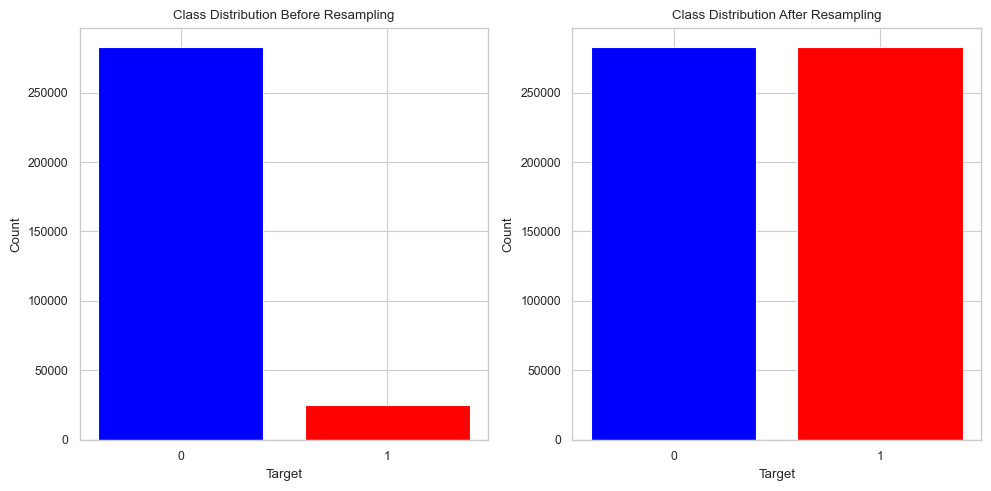

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['0', '1'], df_train_cleaned['TARGET'].value_counts(), color=['blue', 'red'])
plt.title('Class Distribution Before Resampling')
plt.xlabel('Target')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(['0', '1'], pd.Series(y_resampled).value_counts(), color=['blue', 'red'])
plt.title('Class Distribution After Resampling')
plt.xlabel('Target')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [61]:
numerical_cols = [col for col in df_train_cleaned.columns.tolist() if col not in categorical_cols and col != 'TARGET']

In [62]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(df_train_cleaned[numerical_cols]), columns=numerical_cols)

In [63]:
std.sample(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
49267,-0.59592,2.078673,-0.847488,-1.001234,-0.765127,2.083365,-1.228922,-0.351892,-0.170895,-1.596082,0.0,0.0,0.0,0.0,-0.625259,0.0,-0.163276,0.0,0.0,1.214148,0.0,0.0,0.0,0.0,0.0,0.0,0.998154,-0.056135,-0.725764,0.0,-0.722122,0.0,0.446009,0.0,-1.564786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160025,-1.205879,3.082659,1.388176,-0.003607,1.392925,0.664531,-0.387514,-0.029699,-0.053142,-0.076087,-0.195944,0.480562,1.814890,-0.004032,-0.468573,-0.275564,-0.007651,-0.008459,-1.033190,1.762853,-0.185945,-0.112095,-1.565416,0.751986,-0.262121,-0.416421,-0.00255,-0.234957,0.356313,-0.194264,-0.092646,-0.126998,-0.225179,-0.12395,-0.140418,-0.313823,-0.253753,-0.042827,5.101182,-0.041394,-0.98593,-0.082782,-0.27329,-0.16898,-0.093269,-0.049479,-0.341411,-0.065283,-0.149481,-0.066354,-0.444395,-0.351712,-0.235673,-0.443749,-0.461015,-0.45078
168237,-0.59592,-0.069942,-0.906650,-1.006994,-0.831891,0.382140,0.015812,0.749485,0.246587,-1.220448,0.0,0.0,0.0,0.0,1.599337,0.0,-0.163276,0.0,0.0,-1.256186,0.0,0.0,0.0,0.0,0.0,0.0,0.399898,0.264441,-0.128317,0.0,-0.121903,0.0,-0.575808,0.0,-1.564786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [64]:
df_train_cleaned = pd.concat([df_train_cleaned.drop(columns=numerical_cols), std], axis=1)

In [65]:
df_train_cleaned.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,1,-0.59592,0.543948,-0.488320,-0.157903,-0.524778,-0.131961,-1.506880,-1.039675,-0.380063,-0.579154,0.0,0.0,0.0,0.0,1.599337,0.0,-1.300117,0.0,0.0,-0.638603,0.0,0.0,0.0,0.0,0.0,0.0,-1.317940,-2.173696,0.469130,0.0,0.478315,0.0,0.207504,0.0,0.639065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.451167,-1.540726,-0.324395,1.388176,-0.003607,-0.717914,0.664531,-0.387514,-0.029699,-0.053142,-0.076087,-0.195944,0.480562,-0.550997,-0.004032,-0.468573,-0.275564,-0.007651,-0.008459,0.967876,-0.567262,-0.185945,-0.112095,0.638808,-1.329812,-0.262121,2.401419,-0.00255,-0.234957,0.356313,-0.194264,-0.092646,-0.126998,-0.225179,-0.12395,-0.140418,-0.313823,-0.253753,-0.042827,-0.196033,-0.041394,1.01427,-0.082782,-0.27329,-0.16898,-0.093269,-0.049479,-0.341411,-0.065283,-0.149481,-0.066354,-0.444395,-0.351712,-0.235673,-0.443749,-0.461015,2.218375
1,0,-0.59592,1.464783,1.843704,0.670180,1.785244,-1.364897,0.166821,-0.720947,-1.080703,-1.790855,0.0,0.0,0.0,0.0,1.599337,0.0,-0.163276,0.0,0.0,-0.329811,0.0,0.0,0.0,0.0,0.0,0.0,0.564482,0.109944,-0.128317,0.0,-0.121903,0.0,-0.162965,0.0,0.639065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Split Data Train & Test

In [66]:
# select top 25 features
X = df_train_cleaned[['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
                     'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'AGE', 'NAME_EDUCATION_TYPE_Higher education','CODE_GENDER_M', 'EXT_SOURCE_2',
                     'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 'EXT_SOURCE_3', 'NAME_CONTRACT_TYPE_Revolving loans',
                     'OCCUPATION_TYPE_Drivers', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Low-skill Laborers', 'NAME_EDUCATION_TYPE_Secondary / secondary special',
                     'NAME_FAMILY_STATUS_Single / not married', 'FLAG_DOCUMENT_3', 'HOUR_APPR_PROCESS_START', 'NAME_INCOME_TYPE_State servant']]

y = df_train_cleaned['TARGET']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
print(X_train.shape, X_test.shape)

(246008, 25) (61503, 25)


In [69]:
X_train.head()

,AMT_GOODS_PRICE,AMT_CREDIT,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,AGE,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,EXT_SOURCE_2,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,EXT_SOURCE_3,NAME_CONTRACT_TYPE_Revolving loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Low-skill Laborers,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Single / not married,FLAG_DOCUMENT_3,HOUR_APPR_PROCESS_START,NAME_INCOME_TYPE_State servant
123473,-0.190960,-0.097393,0.114225,0.568718,1.675535,-0.395145,1.326176,0.936632,-0.785404,1.640320,-0.567262,-0.720370,-0.816971,2.134139,-1.033190,0.274677,-0.324395,-0.253753,-0.225179,-0.082782,0.638808,-0.416421,0.639065,-0.947395,-0.275564
10118,-1.058887,-1.036580,-0.069942,-1.340471,-1.172323,-0.199922,-1.077031,0.268176,-0.237866,-1.205879,-0.567262,1.388176,-0.126780,-0.468573,0.967876,0.457075,-0.324395,-0.253753,-0.225179,-0.082782,0.638808,-0.416421,0.639065,-1.564978,-0.275564
64716,0.356502,0.483785,-0.376887,-0.160424,1.644371,0.198208,1.206318,1.334791,-0.122327,1.640320,-0.567262,1.388176,0.675334,-0.468573,0.967876,1.095899,-0.324395,3.940835,-0.225179,-0.082782,-1.565416,-0.416421,-1.564786,0.287773,-0.275564
234940,1.104255,0.809031,0.020546,0.055340,-1.222277,-0.673182,-0.522538,-0.161120,0.752176,-1.205879,-0.567262,1.388176,-0.461429,-0.468573,-1.033190,-0.056135,-0.324395,-0.253753,-0.225179,-0.082782,0.638808,-0.416421,-1.564786,-0.638603,-0.275564
236051,-0.150902,-0.154200,0.850893,0.628010,-0.054765,0.860145,-1.154515,1.329491,-0.414393,-0.033915,-0.567262,1.388176,-0.360468,-0.468573,-1.033190,0.068508,-0.324395,-0.253753,-0.225179,-0.082782,0.638808,-0.416421,0.639065,-0.021019,-0.275564


## Modelling

For this modelling section, these are the algorithms that are chosen for this case:

* Random Forest
* Logistic Regression
* Gradient Boosting Classifier
* Neural Networks

### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [71]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 1. Data Train

In [72]:
y_train_pred_rf = rf_model.predict(X_train)


In [73]:
# Print classification report for training data
print('Classification Report Training Model (Random Forest Classifier):')
print(classification_report(y_train, y_train_pred_rf))


Classification Report Training Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226132
           1       1.00      1.00      1.00     19876

    accuracy                           1.00    246008
   macro avg       1.00      1.00      1.00    246008
weighted avg       1.00      1.00      1.00    246008



In [74]:
# Form confusion matrix as a DataFrame for training data
confusion_matrix_rf_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred_rf), 
                                         index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                         columns=['Kredit Lancar', 'Kredit Bermasalah'])

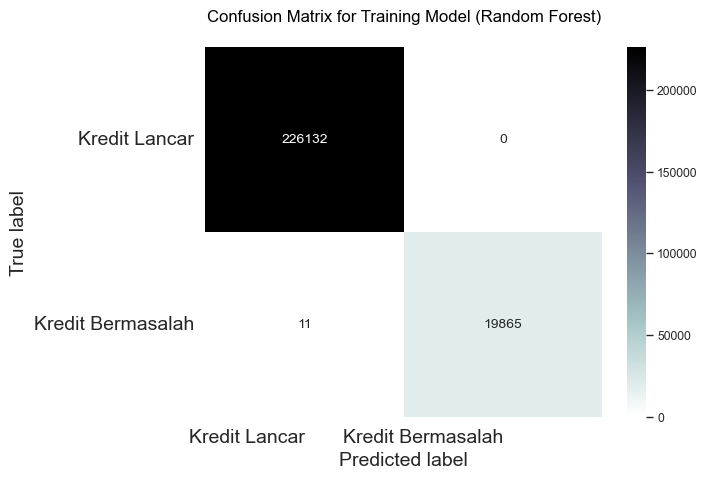

In [75]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf_train, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model (Random Forest)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### 2. Data Test

In [76]:
y_test_pred_rf = rf_model.predict(X_test)

In [77]:
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))


Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.58      0.01      0.02      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [78]:
confusion_matrix_rf_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred_rf), 
                                        index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                        columns=['Kredit Lancar', 'Kredit Bermasalah'])

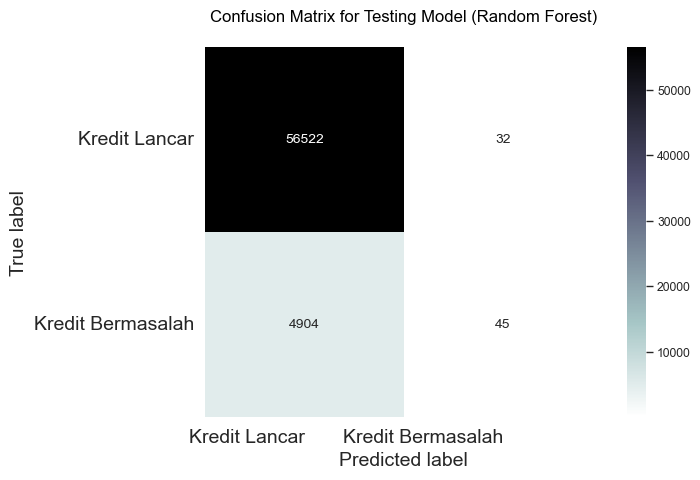

In [79]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf_test, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model (Random Forest)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [80]:
acc_rf_train=round(rf_model.score(X_train,y_train),4)
acc_rf_test=round(rf_model.score(X_test,y_test),4)
print("Training Accuracy:", acc_rf_train)
print("Test Accuracy:", acc_rf_test)

Training Accuracy: 1.0
Test Accuracy: 0.9197


In [81]:
y_train_pred_proba_rf = rf_model.predict_proba(X_train)[:, 1]
auc_roc_train_rf = round(roc_auc_score(y_train, y_train_pred_proba_rf),4)
print(f'AUC-ROC for Training Model: {auc_roc_train_rf}')

y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_roc_test_rf = round(roc_auc_score(y_test, y_test_pred_proba_rf),4)
print(f'AUC-ROC for Testing Model: {auc_roc_test_rf}')

AUC-ROC for Training Model: 1.0
AUC-ROC for Testing Model: 0.712


### Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### 1. Data Train

In [84]:
y_train_pred_logistic = logistic_model.predict(X_train)

In [85]:
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_logistic))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226132
           1       0.48      0.01      0.01     19876

    accuracy                           0.92    246008
   macro avg       0.70      0.50      0.49    246008
weighted avg       0.88      0.92      0.88    246008



In [86]:
confusion_matrix_logistic_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred_logistic), 
                                               index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                               columns=['Kredit Lancar', 'Kredit Bermasalah'])

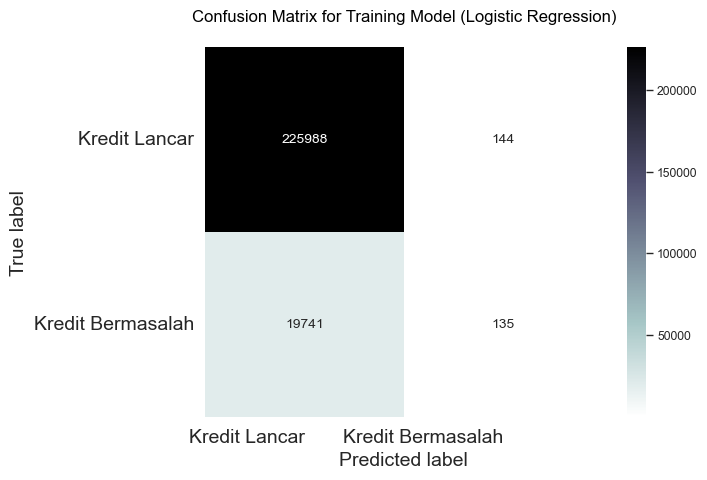

In [87]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_logistic_train, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model (Logistic Regression)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### 2. Data Test

In [88]:
y_test_pred_logistic = logistic_model.predict(X_test)

In [89]:
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_logistic))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.51      0.01      0.01      4949

    accuracy                           0.92     61503
   macro avg       0.72      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [90]:
confusion_matrix_logistic_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred_logistic), 
                                              index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                              columns=['Kredit Lancar', 'Kredit Bermasalah'])

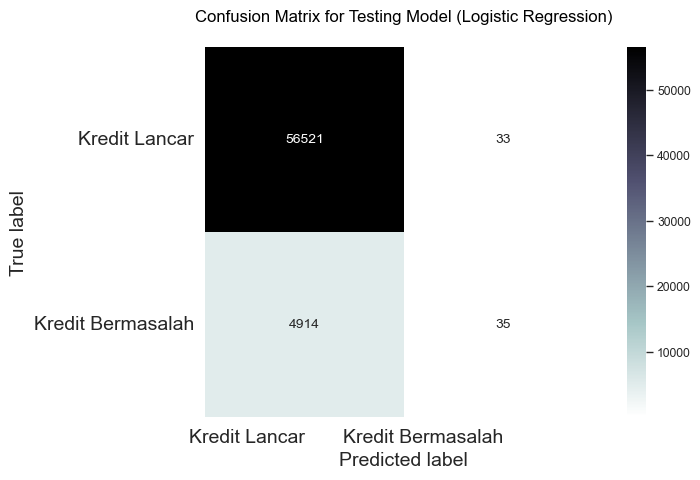

In [91]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_logistic_test, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model (Logistic Regression)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [92]:
acc_log_train=round(logistic_model.score(X_train,y_train),4)
acc_log_test=round(logistic_model.score(X_test,y_test),4)
print("Training Accuracy:", acc_log_train)
print("Test Accuracy:", acc_log_test)

Training Accuracy: 0.9192
Test Accuracy: 0.9196


In [93]:
y_train_pred_proba_lr = logistic_model.predict_proba(X_train)[:, 1]
auc_roc_train_lr = round(roc_auc_score(y_train, y_train_pred_proba_lr),4)
print(f'AUC-ROC for Training Model: {auc_roc_train_lr}')

y_test_pred_proba_lr = logistic_model.predict_proba(X_test)[:, 1]
auc_roc_test_lr = round(roc_auc_score(y_test, y_test_pred_proba_lr),4)
print(f'AUC-ROC for Testing Model: {auc_roc_test_lr}')

AUC-ROC for Training Model: 0.7345
AUC-ROC for Testing Model: 0.7375


### Gradient Boosting Classifier

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

In [95]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

#### 1. Data Train

In [96]:
y_train_pred_gb = gb_model.predict(X_train)

In [97]:
print('Classification Report Training Model (Gradient Boosting Classifier):')
print(classification_report(y_train, y_train_pred_gb))

Classification Report Training Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226132
           1       0.64      0.01      0.02     19876

    accuracy                           0.92    246008
   macro avg       0.78      0.51      0.49    246008
weighted avg       0.90      0.92      0.88    246008



In [98]:
confusion_matrix_gb_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred_gb), 
                                         index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                         columns=['Kredit Lancar', 'Kredit Bermasalah'])

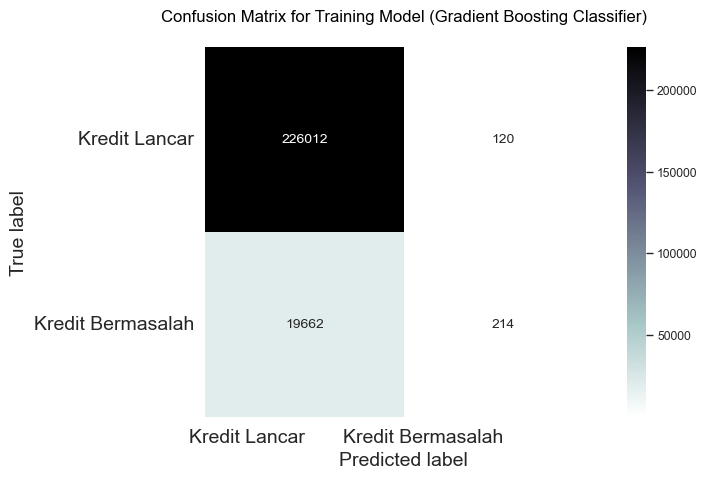

In [99]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gb_train, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model (Gradient Boosting Classifier)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### 2. Data Test

In [100]:
y_test_pred_gb = gb_model.predict(X_test)

In [101]:
print('Classification Report Testing Model (Gradient Boosting Classifier):')
print(classification_report(y_test, y_test_pred_gb))

Classification Report Testing Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.55      0.01      0.02      4949

    accuracy                           0.92     61503
   macro avg       0.73      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [102]:
confusion_matrix_gb_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred_gb), 
                                        index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                        columns=['Kredit Lancar', 'Kredit Bermasalah'])

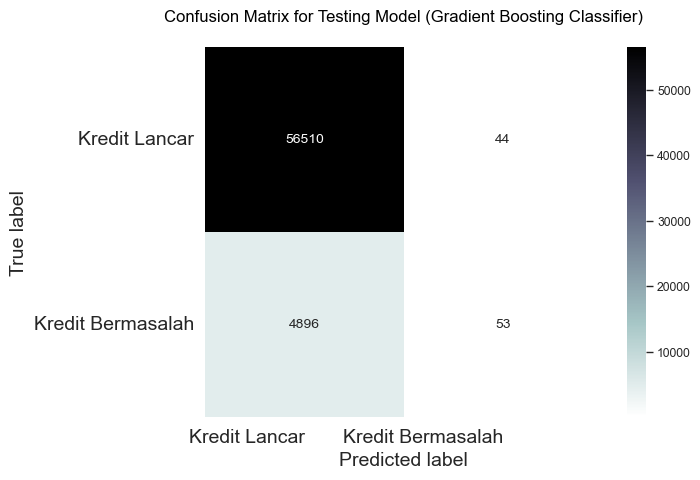

In [103]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gb_test, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model (Gradient Boosting Classifier)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [104]:
acc_gb_train=round(gb_model.score(X_train,y_train),4)
acc_gb_test=round(gb_model.score(X_test,y_test),4)
print("Training Accuracy:", acc_gb_train)
print("Test Accuracy:", acc_gb_test)

Training Accuracy: 0.9196
Test Accuracy: 0.9197


In [105]:
y_train_pred_proba_gb = gb_model.predict_proba(X_train)[:, 1]
auc_roc_train_gb = round(roc_auc_score(y_train, y_train_pred_proba_gb),4)
print(f'AUC-ROC for Training Model: {auc_roc_train_gb}')

y_test_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]
auc_roc_test_gb = round(roc_auc_score(y_test, y_test_pred_proba_gb),4)
print(f'AUC-ROC for Testing Model: {auc_roc_test_gb}')

AUC-ROC for Training Model: 0.7503
AUC-ROC for Testing Model: 0.7432


### Neural Network

In [106]:
from sklearn.neural_network import MLPClassifier

In [107]:
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, y_train)

MLPClassifier(random_state=42)

#### Data Train

In [108]:
y_train_pred_nn = nn_model.predict(X_train)

In [109]:
print('Classification Report Training Model (Neural Network):')
print(classification_report(y_train, y_train_pred_nn))

Classification Report Training Model (Neural Network):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226132
           1       0.60      0.02      0.04     19876

    accuracy                           0.92    246008
   macro avg       0.76      0.51      0.50    246008
weighted avg       0.89      0.92      0.88    246008



In [110]:
confusion_matrix_nn_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred_nn), 
                                         index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                         columns=['Kredit Lancar', 'Kredit Bermasalah'])

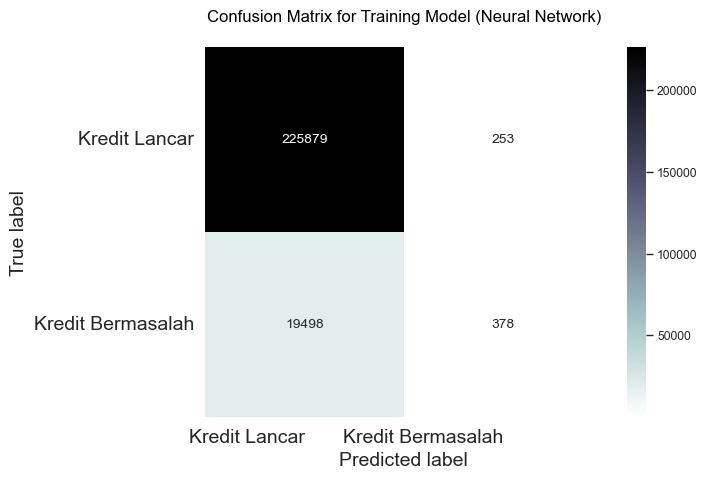

In [111]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn_train, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model (Neural Network)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### Data Test

In [112]:
y_test_pred_nn = nn_model.predict(X_test)

In [113]:
print('Classification Report Testing Model (Neural Network):')
print(classification_report(y_test, y_test_pred_nn))

Classification Report Testing Model (Neural Network):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.51      0.02      0.03      4949

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



In [114]:
confusion_matrix_nn_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred_nn), 
                                        index=['Kredit Lancar', 'Kredit Bermasalah'], 
                                        columns=['Kredit Lancar', 'Kredit Bermasalah'])

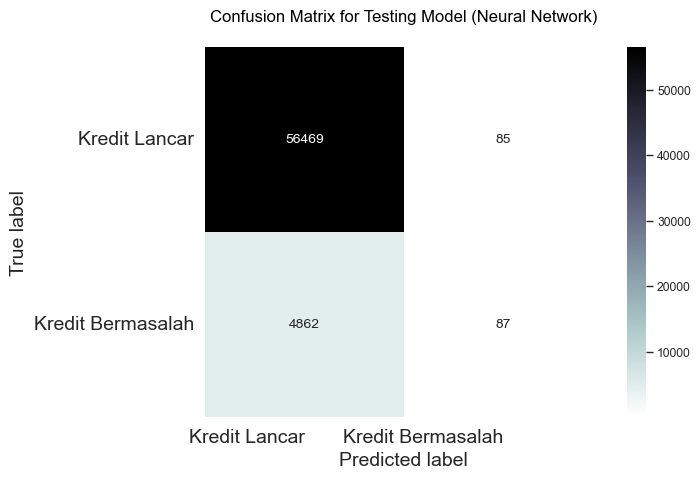

In [115]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn_test, annot=True, annot_kws={'size':10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model (Neural Network)\n', fontsize=12, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [116]:
acc_nn_train=round(nn_model.score(X_train,y_train),4)
acc_nn_test=round(nn_model.score(X_test,y_test),4)
print("Training Accuracy:", acc_nn_train)
print("Test Accuracy:,", acc_nn_test)

Training Accuracy: 0.9197
Test Accuracy:, 0.9196


In [117]:
y_train_pred_proba_nn = nn_model.predict_proba(X_train)[:, 1]
auc_roc_train_nn = round(roc_auc_score(y_train, y_train_pred_proba_nn),4)
print(f'AUC-ROC for Training Model: {auc_roc_train_nn}')

y_test_pred_proba_nn = nn_model.predict_proba(X_test)[:, 1]
auc_roc_test_nn = round(roc_auc_score(y_test, y_test_pred_proba_nn),4)
print(f'AUC-ROC for Testing Model: {auc_roc_test_nn}')

AUC-ROC for Training Model: 0.7637
AUC-ROC for Testing Model: 0.738


## Model Selection

In [118]:
results = pd.DataFrame([["Random Forest", 1.0, 0.9197, 1.0, 0.712],
                        ["Logistic Regression", 0.9192, 0.9196, 0.7345, 0.7375],
                        ["Gradient Boosting", 0.9196, 0.9197, 0.7503, 0.7432],
                        ["Neural Network", 0.9197, 0.9196, 0.7637, 0.738]],
                       columns=["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Train Score", "ROC Test Score"])

styled_results = results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

styled_results

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Train Score,ROC Test Score
0,Random Forest,1.000000,0.919700,1.000000,0.712000
3,Neural Network,0.919700,0.919600,0.763700,0.738000
2,Gradient Boosting,0.919600,0.919700,0.750300,0.743200
1,Logistic Regression,0.919200,0.919600,0.734500,0.737500


Based on the results provided, the Neural Network model and the Gradient Boosting model have approximately the same performance. However, considering the higher ROC value of the Gradient Boosting model on both train and test data it can be considered slightly better for predicting TARGET labels. So the best model chosen for prediction is **Gradient Boosting**.

## Feature Importance

In [119]:
feature_importance = gb_model.feature_importances_

In [120]:
sorted_idx = np.argsort(feature_importance)[::-1]

In [121]:
feature_names = X_train.columns

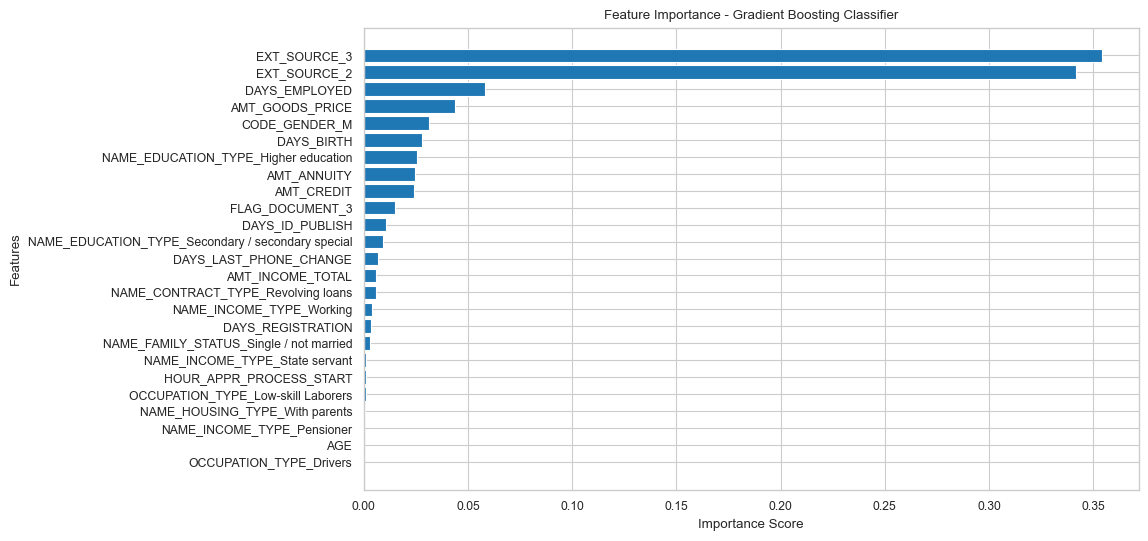

In [122]:
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx][::-1], align='center') 
plt.yticks(range(X_train.shape[1]), np.array(feature_names)[sorted_idx][::-1])  
plt.ylabel('Features')  
plt.xlabel('Importance Score')
plt.title('Feature Importance - Gradient Boosting Classifier')
plt.show()

Based on the feature importance visualization, the Top 5 features are `EXT_SOURCE_3`, `EXT_SOURCE_2`, `DAYS_EMPLOYED`, `AMT_GOODS_PRICE`, and `CODE_GENDER_M`.

## Business Recommendation

**Summary:**

* Target vs Occupation<br>

Occupations with "Laborers" and "Sales Staff" are the most common occupations in the data, and also tend to have a higher number of "Kredit Lancar"(current loans) than "Kredit Bermasalah"(non-performing loans).

Of the two occupations, Sales Staff has a slightly higher ratio of **Kredit Lancar** than Laborers based on the ratio of total to Kredit Lancar/ Kredit Bermasalah. This means that Sales Staff tend to be slightly more current in repaying loans than Laborers.

* Target vs Age<br>

Clients with credit repayment problems were most likely to be in their 30s, while the least likely to have credit repayment problems were in their 60s.


* Target vs Contract Type<br>

From the comparison of total and Kredit Lancar, as well as Kredit Bermasalah, it can be seen that Cash loans perform better than Revolving loans:

1. The total amount of "Kredit Lancar"(current loans) in Cash loans is higher than Revolving loans.
2. The total number of "Kredit Bermasalah"(non-performing loans) in Cash loans is lower than Revolving loans.

Based on this comparison, Cash loans can be considered better performing than Revolving loans.

**Recommendation:**

1. The occupations **Laborers** and **Sales Staff** are among the professions with the largest numbers in the data. Companies can strengthen marketing strategies by focusing more on client segments that tend to have higher current credit, thus targeting marketing more effectively to these segments.

2. Clients in their **30s** tend to experience credit repayment problems, companies can offer credit products that are more suitable for their needs and financial conditions such as providing special benefits such as more flexible payment terms.

3. **Cash loans** perform better than Revolving loans, the company can increase promotion through campaigns and product development of Cash loans.